### **Proyecto 1 NLP – Clasificación supervisada**
#### Curso: Procesamiento de Lenguaje Natural
#### Universidad del Valle de Guatemala
#### **Autores:** José Pablo Orellana y Diego Alberto Leiva
- - -

### Librerías

In [43]:
import pandas as pd
import re, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SpanishStemmer
import nltk
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

- - -

## Preprocesamiento del Corpus

### Cargar Corpus

In [15]:
# Corpus obtenido en Kaggle: https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish

path = "Data/reviews_imdb_es.csv"
df = pd.read_csv(path)

print(f"Registros totales: {len(df)}")
print(df.head(3))

Registros totales: 3001
   Unnamed: 0                                          review_en  \
0           0  One of the other reviewers has mentioned that ...   
1           1  A wonderful little production. The filming tec...   
2           2  I thought this was a wonderful way to spend ti...   

                                           review_es sentiment sentimiento  
0  Uno de los otros críticos ha mencionado que de...  positive    positivo  
1  Una pequeña pequeña producción.La técnica de f...  positive    positivo  
2  Pensé que esta era una manera maravillosa de p...  positive    positivo  


### Renombrar correctamente las columnas y mapear etiquetas en binario.

In [22]:
# Carga total 
df = pd.read_csv(
    path,
    sep=None,
    engine="python",
    quotechar='"',
    escapechar="\\",
    encoding="utf-8",
    on_bad_lines="skip"
)

# --- Limpieza de columnas ---
drop_cols = [c for c in df.columns if str(c).strip().lower().startswith("unnamed") or str(c).strip()==""]
if drop_cols:
    df = df.drop(columns=drop_cols)

# Normalizar los nombres
df.columns = [str(c).strip().lower() for c in df.columns]
print("Columnas originales:", df.columns.tolist())

# Verificamos que existan las columnas necesarias
if "review_es" not in df.columns:
    raise ValueError("No se encontró la columna 'review_es' en el archivo CSV.")
if "sentimiento" not in df.columns and "sentiment" not in df.columns:
    raise ValueError("No se encontró una columna de sentimiento ('sentimiento' o 'sentiment').")

# Escoger la correcta
col_text = "review_es"
col_label = "sentimiento" if "sentimiento" in df.columns else "sentiment"

# Mantener solo esas y renombrar
df = df[[col_text, col_label]].rename(columns={col_text: "reseña", col_label: "sentimiento"})

# Mapear etiquetas a 0/1 si son texto
mapa = {
    "positivo": 1, "positive": 1, "pos": 1, "1": 1, 1: 1, True: 1,
    "negativo": 0, "negative": 0, "neg": 0, "0": 0, 0: 0, False: 0
}
df["sentimiento"] = df["sentimiento"].astype(str).str.strip().str.lower().map(mapa)

# Quitar vacíos o nulos
df = df.dropna(subset=["reseña", "sentimiento"])
df = df[df["reseña"].astype(str).str.strip().str.len() > 0].reset_index(drop=True)

print(f"Filas válidas: {len(df):,}")
print(df.head(3))

Columnas originales: ['review_en', 'review_es', 'sentiment', 'sentimiento']
Filas válidas: 3,001
                                              reseña  sentimiento
0  Uno de los otros críticos ha mencionado que de...            1
1  Una pequeña pequeña producción.La técnica de f...            1
2  Pensé que esta era una manera maravillosa de p...            1


### Normalización de texto

In [25]:
# Normalización del texto
def limpiar_texto(texto: str) -> str:
    # 1) a minúsculas
    s = str(texto).lower().strip()
    # 2) quitar tildes/diacríticos
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    # 3) remover URLs, emails, @usuarios, #hashtags
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    s = re.sub(r'\S+@\S+\.\S+', ' ', s)
    s = re.sub(r'[@#]\w+', ' ', s)
    # 4) dejar solo letras y espacios (mantiene ñ/ü ya sin tilde -> n/u)
    s = re.sub(r'[^a-zñü\s]', ' ', s)
    # 5) espacios múltiples a uno
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

# Crear columna normalizada
df['reseña_limpia'] = df['reseña'].astype(str).apply(limpiar_texto)

# Vistazo rápido
print("Ejemplo (antes y después):\n")
for i in range(5):
    print(f"- Original: {df['reseña'].iloc[i][:120]}...")
    print(f"  Limpia  : {df['reseña_limpia'].iloc[i][:120]}...\n")

# Chequeos básicos
n_vacias = (df['reseña_limpia'].str.len() == 0).sum()
print(f"Filas totales: {len(df):,} | Vacías tras limpieza: {n_vacias:,}")


Ejemplo (antes y después):

- Original: Uno de los otros críticos ha mencionado que después de ver solo 1 Oz Episodio, estará enganchado. Tienen razón, ya que e...
  Limpia  : uno de los otros criticos ha mencionado que despues de ver solo oz episodio estara enganchado tienen razon ya que esto e...

- Original: Una pequeña pequeña producción.La técnica de filmación es muy incuestionable, muy antigua, la moda de la BBC y le da una...
  Limpia  : una pequena pequena produccion la tecnica de filmacion es muy incuestionable muy antigua la moda de la bbc y le da una s...

- Original: Pensé que esta era una manera maravillosa de pasar tiempo en un fin de semana de verano demasiado caliente, sentado en e...
  Limpia  : pense que esta era una manera maravillosa de pasar tiempo en un fin de semana de verano demasiado caliente sentado en el...

- Original: Básicamente, hay una familia donde un niño pequeño (Jake) piensa que hay un zombie en su armario y sus padres están luch...
  Limpia  : basic

### Stopwords

In [31]:
# Stopwords PERSONALIZADAS (sentimiento)

# 1) Intentar disponer de stopwords NLTK 
try:
    from nltk.corpus import stopwords
except Exception:
    try:
        nltk.download('stopwords', quiet=True)
    except Exception:
        pass
    from nltk.corpus import stopwords

def _norm(s: str) -> str:
    # misma normalización: minúsculas + sin diacríticos + espacios compactados
    s = s.lower().strip()
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = re.sub(r'\s+', ' ', s)
    return s

# 2) Base de stopwords 
try:
    sw_base = set(stopwords.words("spanish"))
except Exception:
    sw_base = set("""
a al algo algunas algunos ante antes como con contra cual cuales cuando de del desde donde durante e el ella ellas ellos en 
entre era erais eramos eran es esa esas ese eso esos esta estaba estaban estabais estabamos estas estan estar estara este estos 
fui fue fueron hemos hay la las le les lo los me mi mientras nada ni nos nosotras nosotros o os para pues que se ser si sin 
sobre su sus te ti tiene tienen tuvo un una uno unos y ya
""".split())

# Normaliza igual que el texto
sw_base = {_norm(w) for w in sw_base}

# 3) Palabras que **NO** se eliminan
preservar = {
    # Negaciones
    "no","ni","nunca","jamas","sin","tampoco",
    # Contrastivos
    "pero","aunque",
    # Intensificadores/atenuadores
    "muy","bastante","demasiado","poco","nada","apenas",
    "totalmente","sumamente","realmente","tan","mas","menos","super","re"
}
preservar = {_norm(w) for w in preservar}

# 4) Construir la lista
stopwords_custom = sorted([w for w in sw_base if w not in preservar])
stopwords_custom_set = set(stopwords_custom)

print(f"Stopwords base: {len(sw_base)} | preservadas: {len(preservar)} | usadas (custom): {len(stopwords_custom)}")

# 5) Crea un texto sin stopwords
def quitar_stopwords(texto: str):
    # reseña_limpia tiene solo letras y espacios, por lo que dividir por espacio es suficiente
    toks = texto.split()
    toks = [t for t in toks if t not in stopwords_custom_set]
    return toks

df["tokens_sin_stop"] = df["reseña_limpia"].apply(quitar_stopwords)
df["reseña_sin_stop"] = df["tokens_sin_stop"].apply(lambda ts: " ".join(ts))

# 6) Vista rápida
print("\nEjemplos (antes y sin stopwords):\n")
for i in range(5):
    print(f"- Limpia : {df['reseña_limpia'].iloc[i][:120]}...")
    print(f"  SinSW : {df['reseña_sin_stop'].iloc[i][:120]}...\n")

# (Opcional) pequeña métrica de reducción de vocabulario en una muestra
muestra = df["reseña_limpia"].sample(min(20000, len(df)), random_state=42)
vocab_antes = set(" ".join(muestra).split())
muestra2 = df.loc[muestra.index, "reseña_sin_stop"]
vocab_despues = set(" ".join(muestra2).split())
print(f"Vocab (muestra) antes: {len(vocab_antes):,} | después: {len(vocab_despues):,}")


Stopwords base: 88 | preservadas: 22 | usadas (custom): 85

Ejemplos (antes y sin stopwords):

- Limpia : uno de los otros criticos ha mencionado que despues de ver solo oz episodio estara enganchado tienen razon ya que esto e...
  SinSW : otros criticos ha mencionado despues ver solo oz episodio enganchado razon esto exactamente sucedio conmigo primera cosa...

- Limpia : una pequena pequena produccion la tecnica de filmacion es muy incuestionable muy antigua la moda de la bbc y le da una s...
  SinSW : pequena pequena produccion tecnica filmacion muy incuestionable muy antigua moda bbc da sensacion realismo reconfortante...

- Limpia : pense que esta era una manera maravillosa de pasar tiempo en un fin de semana de verano demasiado caliente sentado en el...
  SinSW : pense manera maravillosa pasar tiempo fin semana verano demasiado caliente sentado teatro aire acondicionado observando ...

- Limpia : basicamente hay una familia donde un nino pequeno jake piensa que hay un zombie en s

### Tokenización + Stemming

In [33]:
# TOKENIZACIÓN + STEMMING 

# 1) Tokenizar: tu texto ya está normalizado y sin signos
df["tokens"] = df["reseña_sin_stop"].str.split()

# 2) Stemming en español
try:
    from nltk.stem.snowball import SpanishStemmer
    _stemmer = SpanishStemmer()
    def stem(t): return _stemmer.stem(t)
except Exception:
    def stem(t): return t  # si no hay stemmer, deja el token tal cual

df["tokens_stem"] = df["tokens"].apply(lambda toks: [stem(t) for t in toks])
df["reseña_stem"] = df["tokens_stem"].apply(lambda ts: " ".join(ts))

print(df[["reseña_sin_stop","tokens","tokens_stem"]].head(5))

                                     reseña_sin_stop  \
0  otros criticos ha mencionado despues ver solo ...   
1  pequena pequena produccion tecnica filmacion m...   
2  pense manera maravillosa pasar tiempo fin sema...   
3  basicamente familia nino pequeno jake piensa z...   
4  amor tiempo petter mattei pelicula visualmente...   

                                              tokens  \
0  [otros, criticos, ha, mencionado, despues, ver...   
1  [pequena, pequena, produccion, tecnica, filmac...   
2  [pense, manera, maravillosa, pasar, tiempo, fi...   
3  [basicamente, familia, nino, pequeno, jake, pi...   
4  [amor, tiempo, petter, mattei, pelicula, visua...   

                                         tokens_stem  
0  [otros, critic, ha, mencion, despu, ver, sol, ...  
1  [pequen, pequen, produccion, tecnic, filmacion...  
2  [pens, maner, maravill, pas, tiemp, fin, seman...  
3  [basic, famili, nin, pequen, jak, piens, zombi...  
4  [amor, tiemp, pett, mattei, pelicul, visual, i..

### Levenshtein

In [36]:
# 1) Distancia de Levenshtein (iterativa, O(m*n)) 
def levenshtein(a: str, b: str) -> int:
    m, n = len(a), len(b)
    if m == 0: return n
    if n == 0: return m
    dp = list(range(n+1))
    for i in range(1, m+1):
        prev, dp[0] = dp[0], i
        for j in range(1, n+1):
            cur = prev if a[i-1] == b[j-1] else prev + 1
            cur = min(cur, dp[j] + 1, dp[j-1] + 1)
            prev, dp[j] = dp[j], cur
    return dp[-1]

# 2) Vocabulario sobre el texto normalizado 
vocab = Counter(" ".join(df["reseña_limpia"]).split())

RARE_MAX_FREQ   = 2   # palabras con frecuencia <=2 se consideran "raras"
COMMON_MIN_FREQ = 5   # y >=5 "comunes" (ajusta según tamaño de corpus)

rare   = [w for w,c in vocab.items() if c <= RARE_MAX_FREQ and len(w) >= 4]
common = [w for w,c in vocab.items() if c >= COMMON_MIN_FREQ]

# pequeña indexación por prefijo para acelerar búsquedas
buckets = defaultdict(list)
for w in common:
    buckets[w[:2]].append(w)

def mejor_vecino(word: str, max_d=2):
    cand = buckets.get(word[:2], []) + buckets.get(word[:1], [])
    best, best_d = None, 99
    for c in cand:
        if abs(len(c) - len(word)) > max_d:
            continue
        d = levenshtein(word, c)
        if d < best_d:
            best, best_d = c, d
            if best_d == 1:
                break
    return best, best_d

# limita el número de raras para tiempo de cómputo (sube si tu máquina puede)
MAX_RARE = 2000
subset_rare = rare[:MAX_RARE]

sugerencias = {}
for w in subset_rare:
    cand, dist = mejor_vecino(w, max_d=2)
    if cand is not None and dist <= 2:
        sugerencias[w] = cand

print(f"Sugerencias generadas: {len(sugerencias)} sobre {len(subset_rare)} palabras raras.")

# 3) Aplicar correcciones al texto
def aplicar_correcciones(texto: str, corr: dict):
    toks = texto.split()
    toks = [corr.get(t, t) for t in toks]
    return " ".join(toks)

# Versión corregida del normalizado y del sin stopwords
df["reseña_limpia_corr"]   = df["reseña_limpia"].apply(lambda s: aplicar_correcciones(s, sugerencias))
df["reseña_sin_stop_corr"] = df["reseña_sin_stop"].apply(lambda s: aplicar_correcciones(s, sugerencias))

# (Opcional) stemming sobre el texto corregido sin stopwords
df["tokens_corr"]      = df["reseña_sin_stop_corr"].str.split()
df["tokens_stem_corr"] = df["tokens_corr"].apply(lambda ts: [stem(t) for t in ts])

print(df[["reseña_limpia","reseña_limpia_corr"]].head(5))
print(df[["reseña_sin_stop","reseña_sin_stop_corr"]].head(5))


Sugerencias generadas: 1058 sobre 2000 palabras raras.
                                       reseña_limpia  \
0  uno de los otros criticos ha mencionado que de...   
1  una pequena pequena produccion la tecnica de f...   
2  pense que esta era una manera maravillosa de p...   
3  basicamente hay una familia donde un nino pequ...   
4  el amor en el tiempo de petter mattei es una p...   

                                  reseña_limpia_corr  
0  uno de los otros criticos ha mencionado que de...  
1  una pequena pequena produccion la tecnica de f...  
2  pense que esta era una manera maravillosa de p...  
3  basicamente hay una familia donde un nino pequ...  
4  el amor en el tiempo de peter mattei es una pe...  
                                     reseña_sin_stop  \
0  otros criticos ha mencionado despues ver solo ...   
1  pequena pequena produccion tecnica filmacion m...   
2  pense manera maravillosa pasar tiempo fin sema...   
3  basicamente familia nino pequeno jake piensa z...  

- - -

## Representación del Texto

### BoW y TF-IDF

In [38]:
# 2.1 BoW y TF-IDF (document-term matrices)

# Mejor columna ya preparada
TEXT_COL = "reseña_sin_stop_corr" if "reseña_sin_stop_corr" in df.columns \
       else ("reseña_sin_stop" if "reseña_sin_stop" in df.columns else "reseña_limpia")

print("Usando columna para vectorizar:", TEXT_COL)

# Bag of Words (1-2 gram)
bow_vec = CountVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.95,
    token_pattern=r"(?u)\b[a-zñü]{2,}\b",   # acorde a normalización
    lowercase=False
)
X_bow = bow_vec.fit_transform(df[TEXT_COL].astype(str))
print("BoW shape:", X_bow.shape)

# TF-IDF (1-2 gram)
tfidf_vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.95,
    token_pattern=r"(?u)\b[a-zñü]{2,}\b",
    lowercase=False
)
X_tfidf = tfidf_vec.fit_transform(df[TEXT_COL].astype(str))
print("TF-IDF shape:", X_tfidf.shape)


Usando columna para vectorizar: reseña_sin_stop_corr
BoW shape: (3001, 15717)
TF-IDF shape: (3001, 15717)


### Matriz de co-ocurrencia + PPMI

In [40]:
# 2.2 Co-ocurrencia + PPMI
from collections import Counter
from scipy.sparse import coo_matrix

# Tokens a partir del texto normalizado 
def _tokens(s: str): 
    return s.split()

# Usamos el normalizado (sin quitar stopwords para no perder contexto)
TXT_FOR_COOCC = "reseña_sin_stop_corr" 
tokens_list = df[TXT_FOR_COOCC].astype(str).apply(_tokens).tolist()

# Vocabulario por frecuencia 
TOP_VOCAB = 5000
freq = Counter(w for toks in tokens_list for w in toks)
vocab = [w for w,_ in freq.most_common(TOP_VOCAB)]
idx = {w:i for i,w in enumerate(vocab)}

# Construimos co-ocurrencias con ventana simétrica
WINDOW = 2
rows, cols, data = [], [], []
for toks in tokens_list:
    L = len(toks)
    for i, w in enumerate(toks):
        if w not in idx: 
            continue
        wi = idx[w]
        j0 = max(0, i-WINDOW)
        j1 = min(L, i+WINDOW+1)
        for j in range(j0, j1):
            if j == i: 
                continue
            u = toks[j]
            if u in idx:
                rows.append(wi); cols.append(idx[u]); data.append(1)

cooc = coo_matrix((data, (rows, cols)), shape=(len(vocab), len(vocab)), dtype=np.float64).tocsr()
total = cooc.sum()
row_sum = np.array(cooc.sum(axis=1)).ravel()
col_sum = np.array(cooc.sum(axis=0)).ravel()

# PPMI solo sobre entradas no-cero
coo = cooc.tocoo()
p_wu = coo.data / total
p_w  = row_sum[coo.row] / total
p_u  = col_sum[coo.col] / total
ppmi_data = np.maximum(0, np.log2((p_wu + 1e-12) / (p_w * p_u + 1e-12)))
PPMI = coo_matrix((ppmi_data, (coo.row, coo.col)), shape=cooc.shape).tocsr()

density = PPMI.nnz / (PPMI.shape[0] * PPMI.shape[1])
print(f"Co-ocurrencia: {cooc.shape} | PPMI: {PPMI.shape} | densidad PPMI: {density:.6f}")


Co-ocurrencia: (5000, 5000) | PPMI: (5000, 5000) | densidad PPMI: 0.023849


### Embeddings (Word2Vec / FastText)

In [42]:
# 2.3 Word2Vec (Gensim)

# Usamos la versión sin stopwords y con correcciones si existe:
TOK_COL = "tokens_corr" if "tokens_corr" in df.columns else \
          ("tokens_sin_stop" if "tokens_sin_stop" in df.columns else "tokens")

sentences = df[TOK_COL].tolist()

w2v = Word2Vec(
    sentences=sentences,
    vector_size=100, window=5, min_count=5,
    sg=1,           # skip-gram 
    negative=10,
    workers=4,
    epochs=5
)

print("Tamaño del vocabulario W2V:", len(w2v.wv))
for w in ["excelente","horrible","actuacion","guion","aburrida","recomiendo","malo","bueno","hotel","viaje"]:
    if w in w2v.wv:
        print(f"Similares a '{w}':", [p for p,_ in w2v.wv.most_similar(w)[:5]])


Tamaño del vocabulario W2V: 10622
Similares a 'excelente': ['brillante', 'maravillosa', 'excepcional', 'maravilloso', 'increible']
Similares a 'horrible': ['terrible', 'porno', 'mala', 'mediocre', 'cliche']
Similares a 'actuacion': ['direccion', 'escritura', 'rendimiento', 'guion', 'actuando']
Similares a 'guion': ['madera', 'rendimiento', 'escritura', 'deficiente', 'puntuacion']
Similares a 'aburrida': ['entretenida', 'predecible', 'ridicula', 'confusa', 'ingenioso']
Similares a 'recomiendo': ['encarecidamente', 'alquilar', 'estaras', 'cubierta', 'recomendaria']
Similares a 'malo': ['estupido', 'tonto', 'aburrido', 'gracioso', 'ridiculo']
Similares a 'bueno': ['divertido', 'diablos', 'tonto', 'gusto', 'genial']
Similares a 'hotel': ['mexico', 'ex', 'mina', 'sheriff', 'sullivan']
Similares a 'viaje': ['carretera', 'automovil', 'bosque', 'regresa', 'regresar']


### Visualización (PCA / t-SNE)

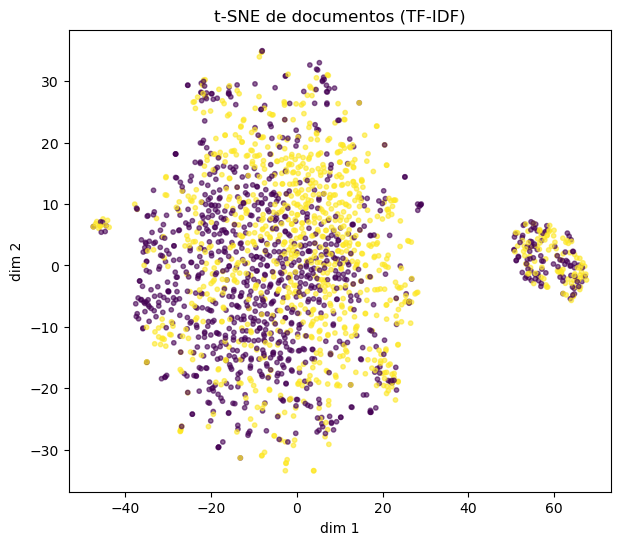

In [44]:
# 2.4 Visualización: PCA -> t-SNE 

# Muestra de documentos para graficar
import numpy as np
n_docs = min(2000, X_tfidf.shape[0])
idx = np.random.RandomState(42).choice(X_tfidf.shape[0], size=n_docs, replace=False)
X_sample = X_tfidf[idx].toarray()   
y_sample = df["sentimiento"].astype(int).values[idx]

# PCA previo para acelerar t-SNE
X_pca = PCA(n_components=50, random_state=42).fit_transform(X_sample)
X_2d  = TSNE(n_components=2, perplexity=30, random_state=42, init="pca").fit_transform(X_pca)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_sample, alpha=0.6, s=10)
plt.title("t-SNE de documentos (TF-IDF)")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.show()


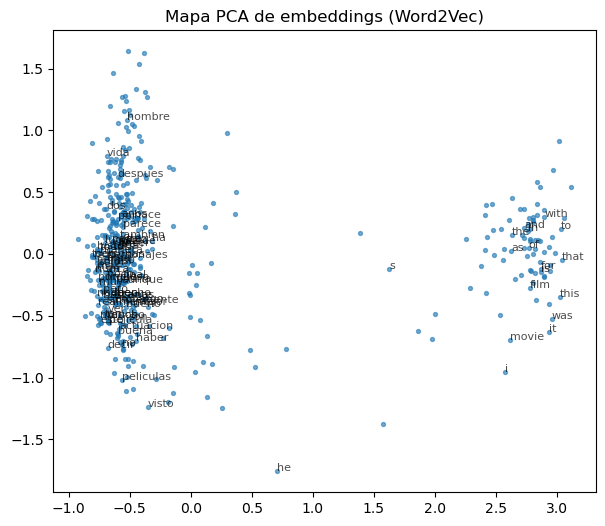

In [45]:
# Mapa 2D de un subconjunto de palabras frecuentes en W2V
from sklearn.decomposition import PCA
words = [w for w,_ in w2v.wv.key_to_index.items()][:500]  # top-500 del vocab
W = np.vstack([w2v.wv[w] for w in words])
W_2d = PCA(n_components=2, random_state=42).fit_transform(W)

plt.figure(figsize=(7,6))
plt.scatter(W_2d[:,0], W_2d[:,1], s=8, alpha=0.6)
for i,w in enumerate(words[:80]):   # anotar algunas para no saturar
    plt.annotate(w, (W_2d[i,0], W_2d[i,1]), fontsize=8, alpha=0.7)
plt.title("Mapa PCA de embeddings (Word2Vec)")
plt.show()
